In [2]:
import sys

sys.path.append('/Users/naormatania/code/cyber-ai/NER/test')

In [20]:
!pip install pandas matplotlib seaborn

  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/8d/07/7e245ce1d7daec77cb1ca3b8caf094afb04c4c552a904787a1d684a2b606/matplotlib-3.8.3-cp311-cp311-macosx_10_12_x86_64.whl.metadata
  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/9b/54/1dafec3c84df1d29119037330f7289db84a679cb2d5283af4ef24d89f532/contourpy-1.2.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb316b96de511b418c53d245aae6/cycler-0.12.1-py3-none-any.whl.metadata
  Obtaining dependency information for fonttools>=4.22.0 from https://files.pythonhosted.org/packages/1f/73/9464c338482c5ebb865585276f27997d66dc

In [22]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ner_eval import Evaluator

In [4]:
_LINE_RE = re.compile(r"^(((\S+)(\s+)?)+) (O|(([IB])-(\S+)))$")

def read_iob_tokens(full_path):
    lines = open(full_path, 'r').readlines()
    lines = [line for line in lines if line != "O\n" and line != " O\n"]
    sent = []
    for line in lines:
        if line == "\n":
            if len(sent) != 0:
                yield sent
            sent = []
            continue
        match_ = re.match(_LINE_RE, line)
        token = match_.group(1)
        postag = match_.group(7)
        label = match_.group(8)
        sent.append((token, postag, label))
    if len(sent) != 0:
        yield sent

def sent2labels(sent, tokens_to_discard=[',','.']):
    return [(token[1], token[2]) for token in sent if token[0] not in tokens_to_discard]

def sent2label_tokens(sent, label, tokens_to_discard=[',','.']):
    return [token[0] for token in sent if token[0] not in tokens_to_discard and token[2] == label]

def change_labels(sent, mapping):
    return [(postag, label) if label not in mapping else (postag, mapping[label]) for postag, label in sent]

def label_count(sents):
    counts = {}
    for sent in sents:
        for token in sent:
            label = token[1]
            if label is None:
                continue
            if label not in counts:
                counts[label] = 1
            else:
                counts[label] = counts[label] + 1
    return counts

def write_label_count(f, sents, name):
    count = label_count(sents)
    f.write(f'{name} label count (Total - {sum(count.values())}):\n')
    f.write(json.dumps(count)+"\n")

def build_iob(sent, default='O'):
    return [f'{postag}-{label}' if label is not None else default for postag, label in sent]

In [5]:
true_sents = list(read_iob_tokens('../DNRTI/iob.txt'))
cyner_sents = list(read_iob_tokens('../test/results/iob_cyner.txt'))
secner_sents = list(read_iob_tokens('../test/results/iob_secner.txt'))
flair_sents = list(read_iob_tokens('../test/results/iob_flair.txt'))

In [6]:
true = [sent2labels(sent) for sent in true_sents]
pred_cyner = [sent2labels(sent) for sent in cyner_sents]
pred_secner = [sent2labels(sent) for sent in secner_sents]
pred_flair = [sent2labels(sent) for sent in flair_sents]

In [9]:
true_to_cyner = {'SamFile': 'Indicator', 'Idus': 'Organization', 'Way': 'System', 
             'OffAct': 'System', 'Tool': 'Malware', 'Exp': 'Vulnerability', 'SecTeam': 'Organization', 
             'HackOrg': 'Organization', 'Org': 'Organization'}
exp1_true_labels = [build_iob(change_labels(sent, true_to_cyner)) for sent in true]
secner_to_cyner = {'PROT': 'Indicator', 'IP': 'Indicator', 'FILE': 'Indicator', 'APT': 'Organization', 'MD5': 'Indicator', 'ACT': 'System',
                'VULID': 'Vulnerability', 'VULNAME': 'Vulnerability', 'ENCR': 'Indicator', 'DOM': 'Indicator', 'EMAIL': 'Indicator', 'TOOL': 'System',
                'SECTEAM': 'Organization', 'SHA2': 'Indicator', 'IDTY': 'Organization', 'OS': 'System', 'URL': 'Indicator', 'MAL': 'Malware', 'LOC': 'Area', 'TIME': 'Time'}
exp1_secner_labels = [build_iob(change_labels(sent, secner_to_cyner)) for sent in pred_secner]
exp1_cyner_labels = [build_iob(sent) for sent in pred_cyner]
flair_to_cyner = {'ORG': 'Organization', 'LOC': 'Area'}
exp1_flair_labels = [build_iob(change_labels(sent, flair_to_cyner)) for sent in pred_flair]

exp1_cyner_evaluator = Evaluator(exp1_true_labels, exp1_cyner_labels, ['Vulnerability', 'Indicator', 'Malware', 'System', 'Organization'])
cyner_results, cyner_results_agg = exp1_cyner_evaluator.evaluate()

exp1_secner_evaluator = Evaluator(exp1_true_labels, exp1_secner_labels, ['Vulnerability', 'Indicator', 'Malware', 'System', 'Organization', 'Time', 'Area'])
secner_results, secner_results_agg = exp1_secner_evaluator.evaluate()

exp1_flair_evaluator = Evaluator(exp1_true_labels, exp1_flair_labels, ['Organization', 'Area'])
flair_results, flair_results_agg = exp1_flair_evaluator.evaluate()

2024-03-10 15:26:07 root INFO: Imported 6575 predictions for 6575 true examples
2024-03-10 15:26:09 root INFO: Imported 6575 predictions for 6575 true examples
2024-03-10 15:26:11 root INFO: Imported 6575 predictions for 6575 true examples


In [16]:
def model_performance(model_name, results):
    return pd.DataFrame([(model_name, match_type, values['precision'], values['recall']) for match_type, values in results.items()], columns=['model_name', 'match_type', 'precision', 'recall'])

In [41]:
all_results = {'cyner': cyner_results, 'secner': secner_results, 'flair': flair_results}
total_performance = pd.concat([model_performance(model_name, results) for model_name, results in all_results.items()])
total_performance

,model_name,match_type,precision,recall
0,cyner,ent_type,0.311440,0.206948
1,cyner,partial,0.588821,0.391265
2,cyner,strict,0.291605,0.193768
3,cyner,exact,0.563288,0.374299
0,secner,ent_type,0.739902,0.697944
1,secner,partial,0.751295,0.708690
2,secner,strict,0.703605,0.663705
3,secner,exact,0.728313,0.687012
0,flair,ent_type,0.551298,0.399909
1,flair,partial,0.547678,0.397284


2024-03-10 15:36:09 matplotlib.pyplot DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-10 15:36:09 matplotlib.pyplot DEBUG: Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-03-10 15:36:09 matplotlib.font_manager DEBUG: findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-03-10 15:36:09 matplotlib.font_manager DEBUG: findfont: score(FontEntry(fname='/Users/naormatania/code/cyber-ai/NER/notebooks/my-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf', name='DejaVu Sans', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 0.33499999999999996
2024-03-10 15:36:09 matplotlib.font_manager DEBUG: findfont: score(FontEntry(fname='/Users/naormatania/code/cyber-ai/NER/notebooks/my-env/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', v

<Axes: xlabel='model_name', ylabel='precision'>

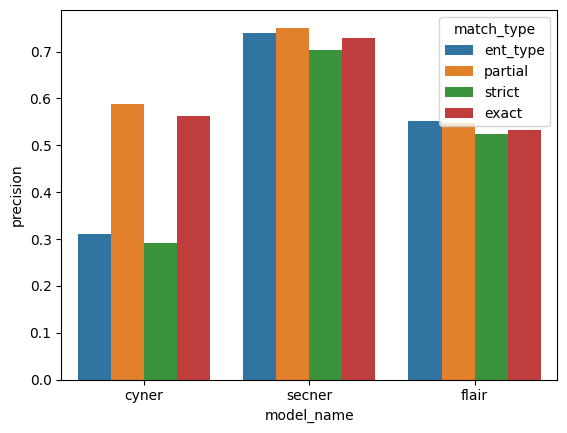

In [23]:
sns.barplot(total_performance, x="model_name", y="precision", hue="match_type")

<Axes: xlabel='model_name', ylabel='recall'>

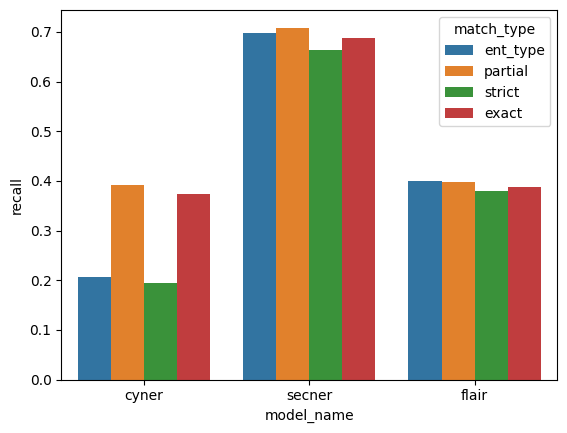

In [24]:
sns.barplot(total_performance, x="model_name", y="recall", hue="match_type")

In [25]:
cyner_results_agg

{'Vulnerability': {'ent_type': {'correct': 589,
   'incorrect': 190,
   'partial': 0,
   'missed': 564,
   'spurious': 4433,
   'possible': 1343,
   'actual': 5212,
   'precision': 0.11300844205679202,
   'recall': 0.43857036485480266},
  'partial': {'correct': 660,
   'incorrect': 0,
   'partial': 119,
   'missed': 564,
   'spurious': 4433,
   'possible': 1343,
   'actual': 5212,
   'precision': 0.13804681504221028,
   'recall': 0.535740878629933},
  'strict': {'correct': 538,
   'incorrect': 241,
   'partial': 0,
   'missed': 564,
   'spurious': 4433,
   'possible': 1343,
   'actual': 5212,
   'precision': 0.1032233307751343,
   'recall': 0.4005956813104989},
  'exact': {'correct': 660,
   'incorrect': 119,
   'partial': 0,
   'missed': 564,
   'spurious': 4433,
   'possible': 1343,
   'actual': 5212,
   'precision': 0.12663085188027629,
   'recall': 0.4914370811615786}},
 'Indicator': {'ent_type': {'correct': 280,
   'incorrect': 536,
   'partial': 0,
   'missed': 844,
   'spurious'

In [32]:
all_results_agg = {'cyner': cyner_results_agg, 'secner': secner_results_agg, 'flair': flair_results_agg}
per_entity_results = pd.concat([pd.concat([model_performance(f'{model_name}/{entity_type}', results) for entity_type, results in results_agg.items()]) for model_name, results_agg in all_results_agg.items()])
per_entity_results

,model_name,match_type,precision,recall
0,cyner/Vulnerability,ent_type,0.113008,0.438570
1,cyner/Vulnerability,partial,0.138047,0.535741
2,cyner/Vulnerability,strict,0.103223,0.400596
3,cyner/Vulnerability,exact,0.126631,0.491437
0,cyner/Indicator,ent_type,0.053343,0.168675
1,cyner/Indicator,partial,0.147742,0.467169
2,cyner/Indicator,strict,0.052581,0.166265
3,cyner/Indicator,exact,0.140027,0.442771
0,cyner/Malware,ent_type,0.170573,0.323491
1,cyner/Malware,partial,0.234217,0.444192


In [35]:
per_entity_results['entity_type'] = per_entity_results['model_name'].map(lambda x: x.split('/')[1])
per_entity_results['model_name'] = per_entity_results['model_name'].map(lambda x: x.split('/')[0])

In [36]:
per_entity_results

,model_name,match_type,precision,recall,entity_type
0,cyner,ent_type,0.113008,0.438570,Vulnerability
1,cyner,partial,0.138047,0.535741,Vulnerability
2,cyner,strict,0.103223,0.400596,Vulnerability
3,cyner,exact,0.126631,0.491437,Vulnerability
0,cyner,ent_type,0.053343,0.168675,Indicator
1,cyner,partial,0.147742,0.467169,Indicator
2,cyner,strict,0.052581,0.166265,Indicator
3,cyner,exact,0.140027,0.442771,Indicator
0,cyner,ent_type,0.170573,0.323491,Malware
1,cyner,partial,0.234217,0.444192,Malware


<Axes: xlabel='entity_type', ylabel='recall'>

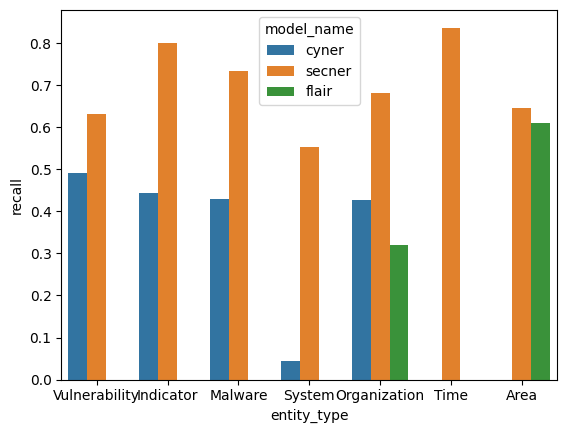

In [37]:
sns.barplot(per_entity_results[per_entity_results['match_type']=='exact'], x="entity_type", y="recall", hue="model_name")

<Axes: xlabel='entity_type', ylabel='precision'>

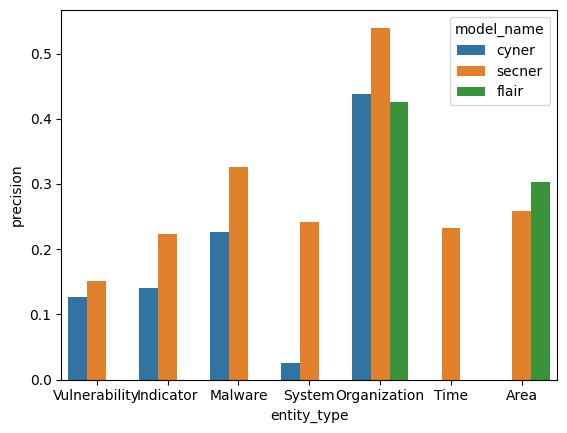

In [38]:
sns.barplot(per_entity_results[per_entity_results['match_type']=='exact'], x="entity_type", y="precision", hue="model_name")